# Model

In [1]:
import os
os.chdir('/home/roobz/Jupyter/afib-detector/src/')

In [2]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

from eda import load_label_map
import random
import pandas as pd
import numpy as np
import optuna

from model import load_train_test_datasets, Afib_CNN, epoch_train, epoch_test, save_model

%load_ext autoreload
%autoreload 2

## Hyperparameter Tuning with Optuna

In [111]:
data_folder = '../data/physionet/afdb/'
window_size = 2500
model_train_kwargs = {
    'train_size': 6000,
    'batch_size': 64,
}
model_test_kwargs = {
    'test_size': 10000,
    'test_batch_size': 1000
}
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
train_dataset, test_dataset = load_train_test_datasets(
    data_folder,
    window_size,
    model_train_kwargs['train_size'],
    model_test_kwargs['test_size'],
    random_seed = 42
)

In [115]:
def objective(trial):
    gamma = trial.suggest_loguniform("gamma", 1e-5, 1-1e-10)
    lr = trial.suggest_loguniform("lr", 1e-2, 1)
    
    model = define_model(trial)
    optimizer = optim.Adadelta(model.parameters(), lr=lr)
    scheduler = StepLR(optimizer, step_size=1, gamma=gamma)
#     scheduler = ReduceLROnPlateau(optimizer, mode='min', patience = 10) 

    
    epochs = 30
    result = None
    for epoch in range(1, epochs+1):
        epoch_train(model, device, train_dataset, optimizer, epoch, **model_train_kwargs)
        acc, avg_loss = epoch_test(model, device, test_dataset, **model_test_kwargs)
        scheduler.step()
        result = avg_loss
        trial.report(result, epoch)
        
        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
        
    return result
    

def define_model(trial):
    repeat_layers = trial.suggest_int('repeat_layers', 1, 4)
    model = Afib_CNN(2500, 2, repeat_layers).to(device)
    return model

In [120]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

pruned_trials = [t for t in study.trials if t.state == optuna.structs.TrialState.PRUNED]
complete_trials = [t for t in study.trials if t.state == optuna.structs.TrialState.COMPLETE]

[I 2021-09-11 20:38:21,102] A new study created in memory with name: no-name-8d4265ad-5967-4383-9d44-7e6a273200c5
[I 2021-09-11 20:40:11,476] Trial 0 finished with value: 0.7367783203125 and parameters: {'gamma': 0.00012772331369366135, 'lr': 0.05841112158537962, 'repeat_layers': 2}. Best is trial 0 with value: 0.7367783203125.
[I 2021-09-11 20:42:00,839] Trial 1 finished with value: 0.733902587890625 and parameters: {'gamma': 0.002149700307714176, 'lr': 0.028419777140572332, 'repeat_layers': 2}. Best is trial 1 with value: 0.733902587890625.
[I 2021-09-11 20:43:57,472] Trial 2 finished with value: 0.7428860473632812 and parameters: {'gamma': 0.011208694286999171, 'lr': 0.0395028801649447, 'repeat_layers': 4}. Best is trial 1 with value: 0.733902587890625.
[I 2021-09-11 20:45:56,880] Trial 3 finished with value: 0.6926365966796875 and parameters: {'gamma': 0.02464489667378558, 'lr': 0.010306410400941065, 'repeat_layers': 4}. Best is trial 3 with value: 0.6926365966796875.
[I 2021-09-11

In [134]:
model_train_kwargs = {
    'train_size': 10000,
    'batch_size': 64,
}
model_test_kwargs = {
    'test_size': 10000,
    'test_batch_size': 1000
}

In [135]:
def train_model(model_args, epochs):
    training_record = []
    try:
        model_args = pd.Series(model_args)
        model = Afib_CNN(
            input_size=2500,
            channels=2,
            repeat_layers=int(model_args.repeat_layers)
        ).to(device)
        optimizer = optim.Adadelta(model.parameters(), lr=model_args.lr)
        scheduler = StepLR(optimizer, step_size=1, gamma=model_args.gamma)

        print(f'Model size after convolutions: {model.fc1_size}')
        for epoch in range(1, epochs+1):
            
            print(f'EPOCH {epoch}:\tlr:{optimizer.param_groups[0]["lr"]: .3g}')
            print(f'Training...', end='')
            train_acc, train_loss = epoch_train(model, device, train_dataset, optimizer, epoch, **model_train_kwargs)
            acc, loss = epoch_test(model, device, test_dataset, **model_test_kwargs)
            scheduler.step()
            print(f'\rTrain Accuracy: {train_acc: .1f}% \tTrain Loss: {train_loss: .4f}')
            print(f'Test Accuracy:  {acc: .1f}% \tTest Loss: {loss: .4f}')
            
            # record training
            training_record.append((train_loss, loss))

            

        return model, training_record
    except KeyboardInterrupt:
        print('\n-----Force Stop-----')
        return model, training_record
    
def record_plot(record, figsize=None):
    record = pd.DataFrame(record, columns=['Train', 'Test'])
    ax = record.plot(xlabel='Epoch', ylabel='Loss', legend=True, figsize=figsize)
    return ax

In [122]:
print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
best_trial = study.best_trial

print("  Value: ", best_trial.value)

print("  Params: ")
for key, value in best_trial.params.items():
    print("    {}: {}".format(key, value))

    
model, training_record = train_model(
    study.best_params, 
    epochs=150)

Study statistics: 
  Number of finished trials:  100
  Number of pruned trials:  73
  Number of complete trials:  27
Best trial:
  Value:  0.6270741577148438
  Params: 
    gamma: 1.6480207312276725e-05
    lr: 0.047516406066688756
    repeat_layers: 3
Model size after convolutions: 27
EPOCH 1:	lr: 0.0475
Train Accuracy:  76.6% 	Train Loss:  0.5407
Test Accuracy:   52.9% 	Test Loss:  0.7054
EPOCH 2:	lr: 7.83e-07
Train Accuracy:  89.0% 	Train Loss:  0.4216
Test Accuracy:   53.3% 	Test Loss:  0.7093
EPOCH 3:	lr: 1.29e-11
Train Accuracy:  89.6% 	Train Loss:  0.4217
Test Accuracy:   53.3% 	Test Loss:  0.7093
EPOCH 4:	lr: 2.13e-16
Train Accuracy:  89.4% 	Train Loss:  0.4216
Test Accuracy:   53.3% 	Test Loss:  0.7093
EPOCH 5:	lr: 3.51e-21
Train Accuracy:  89.4% 	Train Loss:  0.4215
Test Accuracy:   53.3% 	Test Loss:  0.7093
EPOCH 6:	lr: 5.78e-26
Train Accuracy:  89.1% 	Train Loss:  0.4243
Test Accuracy:   53.3% 	Test Loss:  0.7093
EPOCH 7:	lr: 9.52e-31
Train Accuracy:  88.3% 	Train Loss:  0.

In [145]:
model, training_record = train_model(
    {
        'lr': 1e-2,
        'gamma': .75,
        'input_size': 2500,
        'repeat_layers': 1
    }, 
    150)

Model size after convolutions: 91
EPOCH 1:	lr: 0.01
Train Accuracy:  57.2% 	Train Loss:  0.6825
Test Accuracy:   58.8% 	Test Loss:  0.6750
EPOCH 2:	lr: 0.0075
Train Accuracy:  68.0% 	Train Loss:  0.6164
Test Accuracy:   59.2% 	Test Loss:  0.6767
EPOCH 3:	lr: 0.00562
Train Accuracy:  73.5% 	Train Loss:  0.5719
Test Accuracy:   59.3% 	Test Loss:  0.6772
EPOCH 4:	lr: 0.00422
Train Accuracy:  77.5% 	Train Loss:  0.5382
Test Accuracy:   59.6% 	Test Loss:  0.6765
EPOCH 5:	lr: 0.00316
Train Accuracy:  79.1% 	Train Loss:  0.5127
Test Accuracy:   60.1% 	Test Loss:  0.6746
EPOCH 6:	lr: 0.00237
Train Accuracy:  81.7% 	Train Loss:  0.4907
Test Accuracy:   60.4% 	Test Loss:  0.6734
EPOCH 7:	lr: 0.00178
Train Accuracy:  82.3% 	Train Loss:  0.4787
Test Accuracy:   60.1% 	Test Loss:  0.6719
EPOCH 8:	lr: 0.00133
Train Accuracy:  83.4% 	Train Loss:  0.4659
Test Accuracy:   60.2% 	Test Loss:  0.6722
EPOCH 9:	lr: 0.001
Train Accuracy:  84.1% 	Train Loss:  0.4563
Test Accuracy:   59.8% 	Test Loss:  0.6721


<AxesSubplot:xlabel='Epoch', ylabel='Loss'>

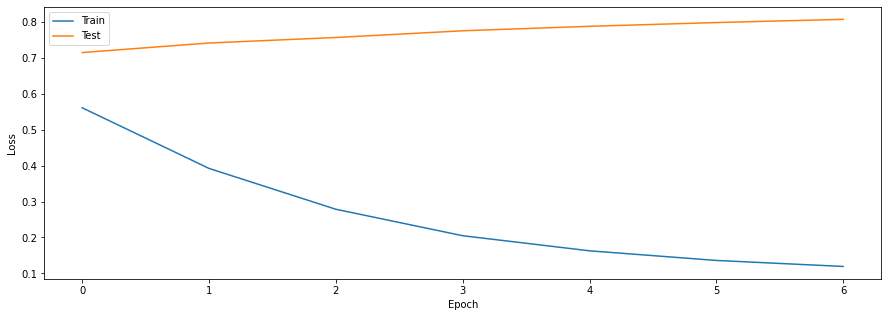

In [143]:
record_plot(training_record, figsize=(15, 5))

In [ ]:
save_model(model, "../afib_detector_cnn.pt")

In [ ]:
pd.DataFrame(
    data=[(trial.value, trial.params) for trial in study.trials],
    columns=['acc', 'params']
).sort_values('acc', ascending=False).to_pickle('../data/cleaned/hyperparameter_optimization.pkl')

In [31]:
print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
best_trial = study.best_trial

print("  Value: ", best_trial.value)

print("  Params: ")
for key, value in best_trial.params.items():
    print("    {}: {}".format(key, value))

Study statistics: 
  Number of finished trials:  100
  Number of pruned trials:  59
  Number of complete trials:  41
Best trial:
  Value:  0.16846804809570312
  Params: 
    gamma: 0.44752485496457467
    lr: 0.8531623835455004
    repeat_layers: 4
